
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [46]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import warnings
warnings.filterwarnings('ignore')

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['__class__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [276]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('regency', 0.242206441914102),
 ('300', 0.1609236660436954),
 ('ci', 0.08340213894062043),
 ('tiled', 0.09901319943986409),
 ('exchangable', 0.19389877721110985),
 ('340', 0.33279218254193177),
 ('dxf', 0.13074268623716792),
 ('micro', 0.08265545268171724),
 ('archie', 0.21470375597395805),
 ('1e9fen960h05', 0.10567912764152107),
 ('poularik', 0.07233572670398213),
 ('sketchpad', 0.10764804579814606),
 ('3802', 0.07820822067701588),
 ('phase', 0.05330795380898169),
 ('xtsetarg', 0.2005964843884056),
 ('ganguly', 0.12966417836781355),
 ('flashed', 0.10398115498242126),
 ('rt30', 0.23003630950953577),
 ('golfs', 0.049362458204248665),
 ('sender', 0.058835911410440596)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [277]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['300', 'protocol', 'value', 'convert', 'program', 'multiple', 'got', 'prices', 'application', '95'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [279]:
km.fit(newsgroupsTFVects)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=9, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [280]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_curve', 'precision_recall_fscore_support', 'precision_score', 'r2_score', 'ranki

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [18]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",1
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,1
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,1
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",1
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,1
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,1
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,1
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",1
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,1
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,1


We can also look at the distinguishing features in each cluster:

In [19]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 car
 cars
 engine
 like
 good
 just
 dealer
 think
 new
 don


Cluster 1:
 know
 just
 thanks
 mac
 does
 drive
 like
 don
 apple
 use


Cluster 2:
 window
 server
 motif
 use
 widget
 program
 application
 using
 like
 windows


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 price




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [20]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [21]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [22]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue'), ('comp.sys.mac.hardware', 'red')])


Let's plot the data using the true labels as the colors of our data points.

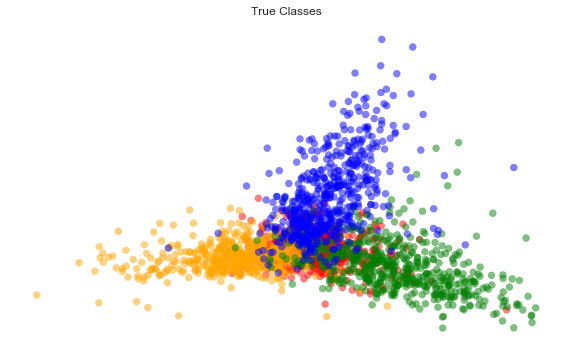

In [23]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

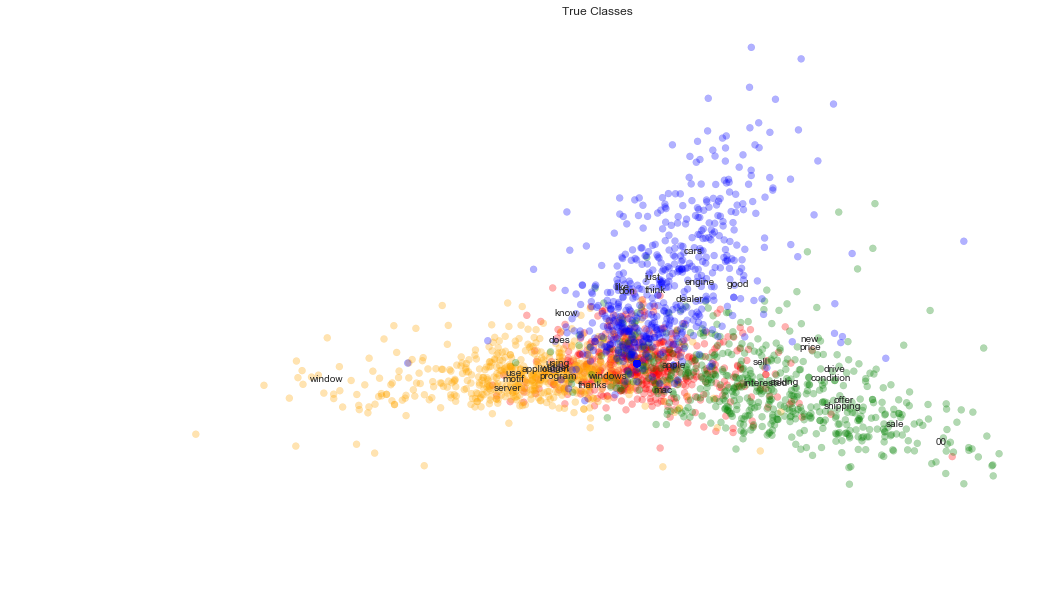

In [24]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

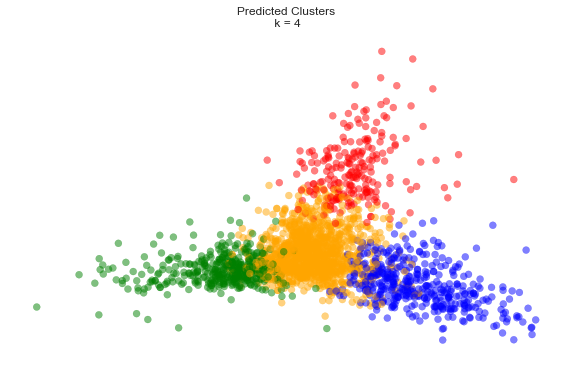

In [26]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [27]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [28]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

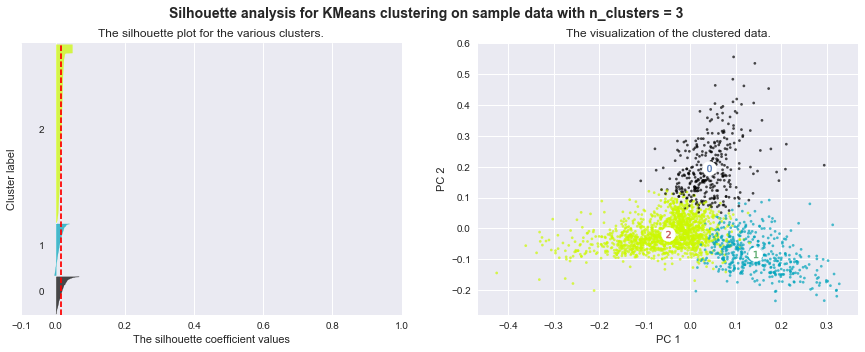

For n_clusters = 3, The average silhouette_score is : 0.014


In [29]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

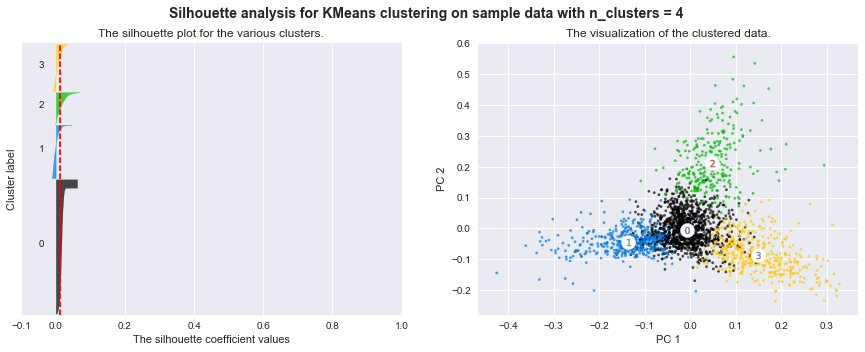

For n_clusters = 4, The average silhouette_score is : 0.012


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

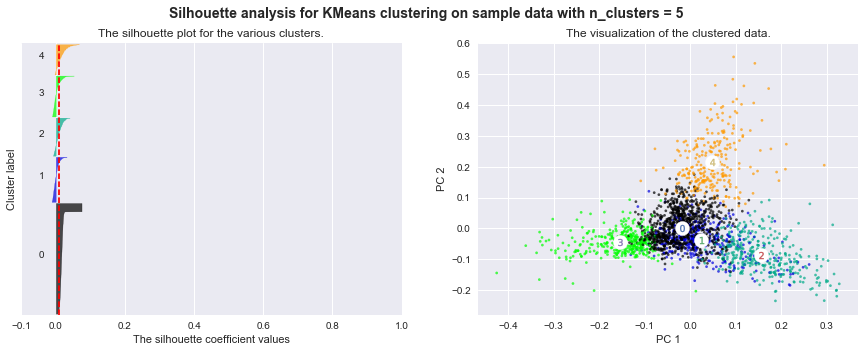

For n_clusters = 5, The average silhouette_score is : 0.011


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

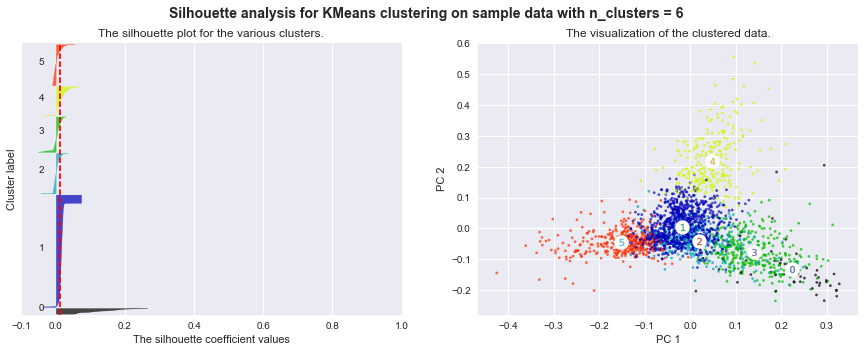

For n_clusters = 6, The average silhouette_score is : 0.013


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [33]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [34]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [281]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [36]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [282]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [38]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

And visualize:

In [39]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

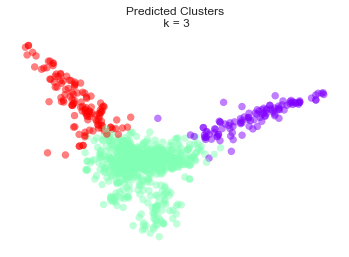

In [40]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters; with Silhouette analysis or maybe some of the metric although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [41]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,2
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

### Prepare for data

The corpora that will be used in this section of the assignmend is 100 chapters of 10 different novels from the same source of the previous assignments. Scraping files and data file is available in the same directory.

In [124]:
novelsDF = pandas.read_csv("tenNovels.csv")
novelsDF.iloc[:10]

,chapter,country,name,shortName,text,url
0,chapter-1,China,Tales of Demons & Gods,tdg,"Even though it’s already the early summer, the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...
1,chapter-2,China,Tales of Demons & Gods,tdg,"Naturally, Nie Li recognized this person. He’s...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...
2,chapter-3,China,Tales of Demons & Gods,tdg,"You… In the hundreds of years of Glory City, L...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...
3,chapter-4,China,Tales of Demons & Gods,tdg,"Aside from having a charming feel to her, she ...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...
4,chapter-5,China,Tales of Demons & Gods,tdg,The Holy Orchid Institute’s annual school fee ...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...
5,chapter-6,China,Tales of Demons & Gods,tdg,"Meanwhile, Du Ze and Nie Li were hiding in the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...
6,chapter-7,China,Tales of Demons & Gods,tdg,Xiao Ning’er didn’t like being disrupted by ot...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...
7,chapter-8,China,Tales of Demons & Gods,tdg,"Don’t misunderstand, I’m only treating your il...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...
8,chapter-9,China,Tales of Demons & Gods,tdg,It’s time for Shen Xiu’s lesson again. However...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...
9,chapter-10,China,Tales of Demons & Gods,tdg,Xiao Ning’er also ate a few pieces of the past...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...


### Convert the documents into word count vectors                                                     

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [74]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()                               
novelsVects = ngCountVectorizer.fit_transform(novelsDF['text'])                                     
print(novelsVects.shape)

(1000, 21699)


### Use method tf-idf to weight document-distinguishing words

In [75]:
novelsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(novelsVects)
novelsTF = novelsTFTransformer.transform(novelsVects)                                               
print(novelsTF.shape)                                                                               
# Show tf-idf for each word in each text                                                            
list(zip(ngCountVectorizer.vocabulary_.keys(), novelsTF.data))[:20]

(1000, 21699)


[('infusion', 0.007630314050532508),
 ('300', 0.004723638118626081),
 ('lull', 0.01242331228419993),
 ('conquer', 0.012089382909834993),
 ('emotional', 0.022869130015844324),
 ('weapon', 0.007515974680678081),
 ('repressed', 0.01670176689515943),
 ('kneels', 0.010315737927335937),
 ('rivulets', 0.014182317990397155),
 ('phase', 0.007643276840318382),
 ('quiver', 0.004577137883896985),
 ('spiritual', 0.004222541660530201),
 ('flashed', 0.01066648112195388),
 ('scryrius', 0.004818097358836281),
 ('tumbling', 0.020279229939514375),
 ('shoulders', 0.009840135909411301),
 ('coins', 0.006156897424498007),
 ('perceptible', 0.01266723242977443),
 ('contours', 0.016483101048020834),
 ('rush', 0.013296202375455056)]

At first glance, there appears to be okay. However, there sare still many words that does not make sense. So filtering of data is needed.

### To prune this matrix of features, limit our word vector to 1000 words with at least 10 occurrences, which do not occur in more than 30% documents.

After filtering data, we could see all words shown are not making more sense.

In [91]:
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.2, max_features=1000, min_df=20, stop_words='english', norm='l2')
novelsTFVects = ngTFVectorizer.fit_transform(novelsDF['text'])                                      
list(zip(ngTFVectorizer.vocabulary_.keys(), novelsTFVects.data))[:20]

[('weapon', 0.016363182212512827),
 ('phase', 0.03216761970565258),
 ('coins', 0.015608765753432676),
 ('flesh', 0.027705679823660626),
 ('east', 0.013174263213739892),
 ('spirits', 0.015650143837364565),
 ('expressions', 0.01577636156663206),
 ('percent', 0.013597874408214878),
 ('pavilion', 0.02894095110254103),
 ('sitting', 0.01498922489035335),
 ('patterns', 0.01577636156663206),
 ('arena', 0.01470591564024044),
 ('ring', 0.017194333449458546),
 ('foundation', 0.015099721839791786),
 ('yuan', 0.027940890961744902),
 ('wrapped', 0.019523454929691354),
 ('wild', 0.026869618033786558),
 ('depths', 0.014603659732360216),
 ('similar', 0.019011751714841905),
 ('floating', 0.06564516701972277)]

## Flat Clustering with K-means                                                                     

As shown above, there are 10 novels, so I would assume there would be of course 10 clusters.

In [92]:
numClusters = 10

### Initialize and calculate cluster

In [93]:
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')           
km.fit(novelsTFVects) 

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

### Evaluate the clusters using some metrics 

In [94]:
print("For our clusters:")                                                      
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(novelsDF['name'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(novelsDF['name'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(novelsDF['name'], km.labels_)))

For our clusters:
Homogeneity: 0.985
Completeness: 0.986
V-measure: 0.986


### Adding cluster labels to the pandas dataframe                                 

In [95]:
novelsDF['kmeans_predictions'] = km.labels_                                     
novelsDF.iloc[:10]

,chapter,country,name,shortName,text,url,kmeans_predictions
0,chapter-1,China,Tales of Demons & Gods,tdg,"Even though it’s already the early summer, the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
1,chapter-2,China,Tales of Demons & Gods,tdg,"Naturally, Nie Li recognized this person. He’s...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
2,chapter-3,China,Tales of Demons & Gods,tdg,"You… In the hundreds of years of Glory City, L...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
3,chapter-4,China,Tales of Demons & Gods,tdg,"Aside from having a charming feel to her, she ...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
4,chapter-5,China,Tales of Demons & Gods,tdg,The Holy Orchid Institute’s annual school fee ...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
5,chapter-6,China,Tales of Demons & Gods,tdg,"Meanwhile, Du Ze and Nie Li were hiding in the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
6,chapter-7,China,Tales of Demons & Gods,tdg,Xiao Ning’er didn’t like being disrupted by ot...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
7,chapter-8,China,Tales of Demons & Gods,tdg,"Don’t misunderstand, I’m only treating your il...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
8,chapter-9,China,Tales of Demons & Gods,tdg,It’s time for Shen Xiu’s lesson again. However...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0
9,chapter-10,China,Tales of Demons & Gods,tdg,Xiao Ning’er also ate a few pieces of the past...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,0


### Assess distinguishing features in each cluster 

Surprisingly, I would first suspect the most important distinguishing words of each novel would be some verbs and adjectives used. However, it seems the most distinguishing words are actually nouns. I suspect it is because these novels frequently used these nouns, such as the Kung Fu master's name, monster's name' repetitively within each chapter. I personally think this is not a writing practice, but the authors and translators seems to do it repetitively regardless.

In [96]:
terms = ngTFVectorizer.get_feature_names()                                      
print("Top terms per cluster:")                                                 
order_centroids = km.cluster_centers_.argsort()[:, ::-1]                        
for i in range(numClusters):                                                    
    print("Cluster %d:" % i)                                                    
    for ind in order_centroids[i, :10]:                                         
        print(' %s' % terms[ind])                                               
    print('\n')  

Top terms per cluster:
Cluster 0:
 nie
 shen
 demon
 ye
 ziyun
 ning
 soul
 sacred
 yue
 hai


Cluster 1:
 qing
 shui
 yu
 yi
 shi
 situ
 wenren
 shuang
 sword
 xiantian


Cluster 2:
 lin
 dong
 lei
 yuan
 zhentian
 xie
 talisman
 manor
 tan
 steel


Cluster 3:
 jiang
 duke
 eastern
 gouyu
 princess
 soaring
 meridians
 fatty
 pill
 xuan


Cluster 4:
 qiye
 cleansing
 incense
 immortal
 emperor
 protector
 saint
 huairen
 physique
 merit


Cluster 5:
 theo
 magic
 theodore
 vince
 tower
 circle
 sylvia
 veronica
 magician
 magicians


Cluster 6:
 mu
 liu
 array
 northern
 territory
 ling
 mubai
 tang
 feng
 mo


Cluster 7:
 nie
 tian
 tao
 pan
 ying
 cloudsoaring
 dimension
 donghai
 tong
 illusion


Cluster 8:
 che
 profound
 yun
 xia
 qingyue
 jasmine
 moon
 palace
 luocheng
 cloud


Cluster 9:
 shi
 village
 precious
 vicious
 willow
 children
 golden
 symbols
 bone
 divine




### In order to construct a visualization of the clusters, first reduce the dimensionality of the data using principal components analysis (PCA).

In [97]:
PCA = sklearn.decomposition.PCA                                                 
pca = PCA(n_components = 2).fit(novelsTFVects.toarray())                        
reduced_data = pca.transform(novelsTFVects.toarray())  

### Build color map for the true labels

In [98]:
colordict = {                                                                   
'Against the Gods': 'red',                                                 
'Ancient Strengthening Technique': 'grey',                                                     
"Emperor's Domination": 'green',   
'Lord of All Realms':'blue',
'Perfect World':'black',
'Sovereign of the Three Realms':'purple',
'Tales of Demons & Gods':'orange',
'The Book Eating Magician':'pink',
'The Great Ruler':'brown',
'Wu Dong Qian Kun':'yellow'
    }  
colors = [colordict[c] for c in novelsDF['name']]                       
print("The categories' colors are:\n{}".format(colordict.items()))  

The categories' colors are:
dict_items([('The Book Eating Magician', 'pink'), ('Lord of All Realms', 'blue'), ('Tales of Demons & Gods', 'orange'), ('Wu Dong Qian Kun', 'yellow'), ('Perfect World', 'black'), ('Against the Gods', 'red'), ('Ancient Strengthening Technique', 'grey'), ('The Great Ruler', 'brown'), ("Emperor's Domination", 'green'), ('Sovereign of the Three Realms', 'purple')])


### Plot the data using the true labels as the colors of our data points.  

I could be sees that: 

First Cluster:
"The Book Eating Magician", 
"Sovereign of the Three Realms"
"Perfect World"
"Emperor's Domination"
"The Great Ruler"
"Against the Gods"

Second Cluster:
"Wu Dong Qian Kun"

Third Cluster:
"Lord of All Realms"
"Tales of Demons & Gods"

Fourth Cluster:
"Ancient Strengthening Technique"

The chapters from the 6 books form a cluster and two books form another cluster, and the rest of clusters form their own cluster. I was surprised to find that as I would expect at least "Wu Dong Qian Kun" to be included in Cluster 1. Looking at the result, I would suspect it is because they are translated byy different translatros, and maybe there are 4 translators working on these 10 novels.

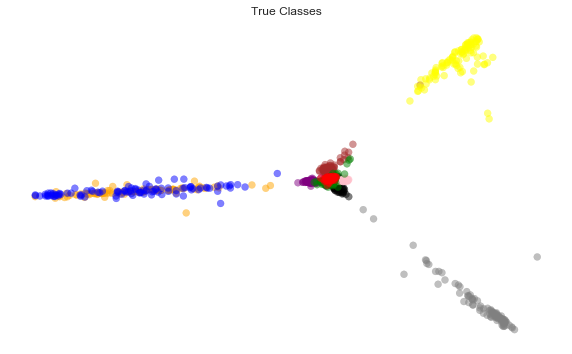

In [99]:
fig = plt.figure(figsize = (10,6))                                              
ax = fig.add_subplot(111)                                                       
ax.set_frame_on(False)                                                          
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())                                                                  
plt.yticks(())                                                                  
plt.title('True Classes')                                                       
plt.show()        

### Create a biplot

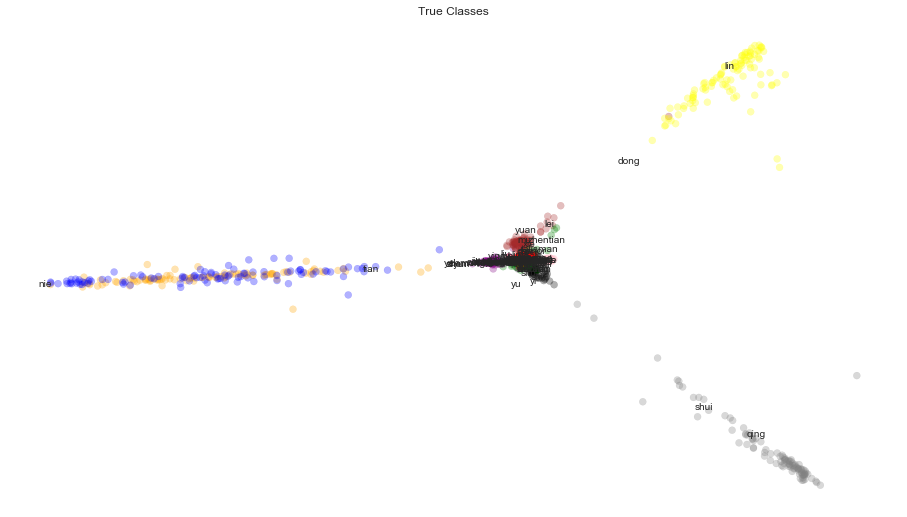

In [100]:
# Prepare for biplot                                                            
components = pca.components_                                                    
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.                
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:] 
fig = plt.figure(figsize = (16,9))                                              
ax = fig.add_subplot(111)                                                       
ax.set_frame_on(False)                                                          
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):                                                
    ax.annotate(word, (x[i],y[i]))                                              
plt.xticks(())                                                                  
plt.yticks(())                                                                  
plt.title('True Classes')                                                       
plt.show()                                                                      

### Repeat with predicted clusters 

In [101]:
chapterCategories = list(set(novelsDF['name']))

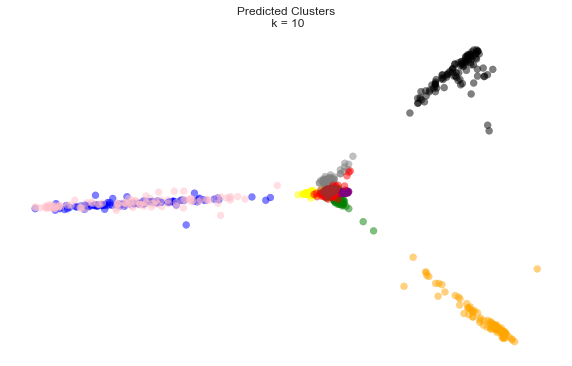

In [102]:
colors_p = [colordict[chapterCategories[l]] for l in km.labels_]             
fig = plt.figure(figsize = (10,6))                                              
ax = fig.add_subplot(111)                                                       
ax.set_frame_on(False)                                                          
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())                                                                  
plt.yticks(())                                                                  
plt.title('Predicted Clusters\n k = 10')                                         
plt.show() 

### Selecting Cluster Number using Silhouette 

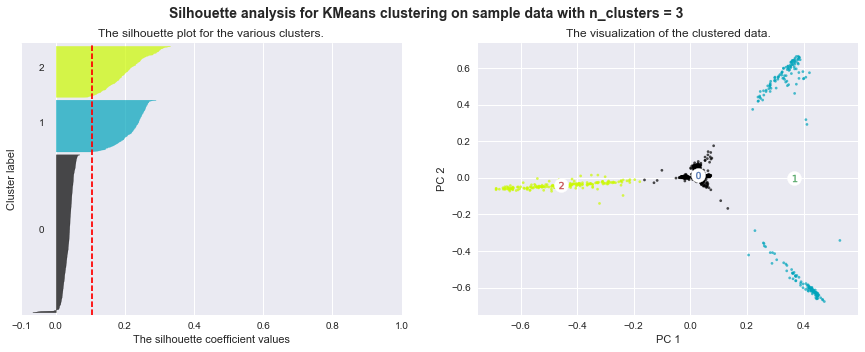

For n_clusters = 3, The average silhouette_score is : 0.105


In [103]:
X = novelsTFVects.toarray()   
plotSilhouette(3, X) 

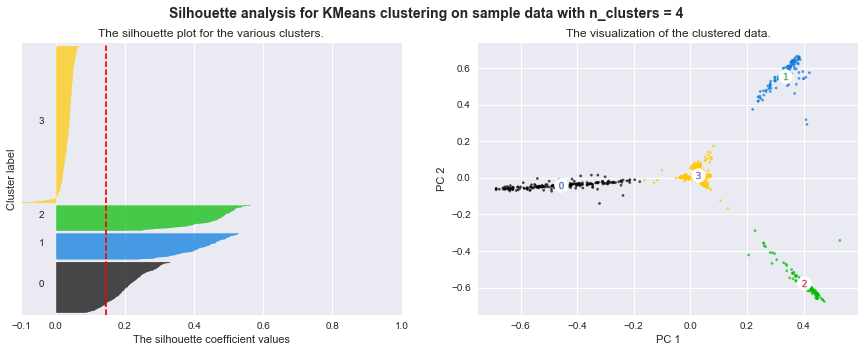

For n_clusters = 4, The average silhouette_score is : 0.146


In [104]:
X = novelsTFVects.toarray()   
plotSilhouette(4, X) 

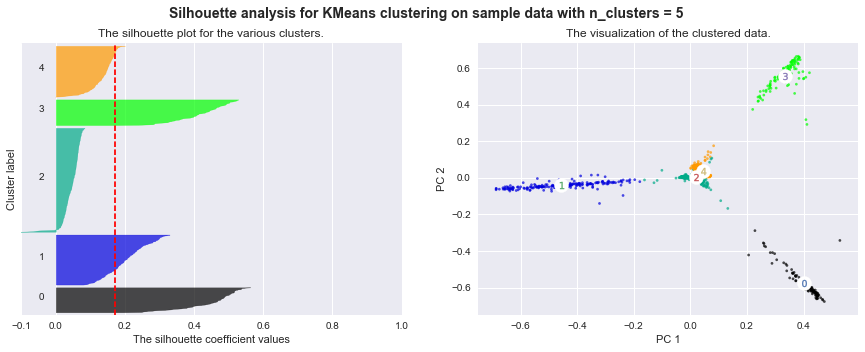

For n_clusters = 5, The average silhouette_score is : 0.171


In [105]:
X = novelsTFVects.toarray()   
plotSilhouette(5, X) 

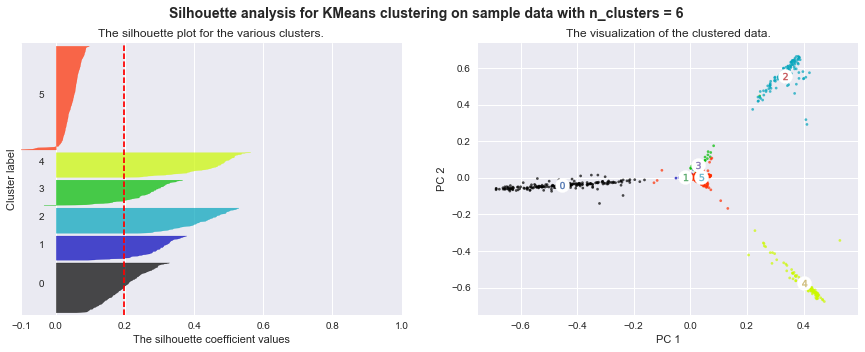

For n_clusters = 6, The average silhouette_score is : 0.196


In [106]:
X = novelsTFVects.toarray()   
plotSilhouette(6, X) 

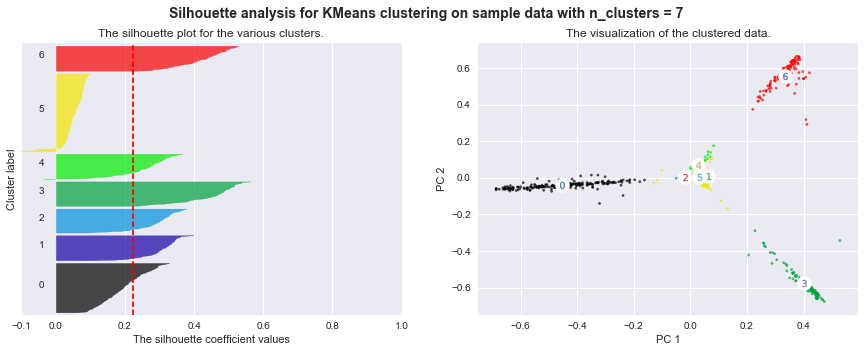

For n_clusters = 7, The average silhouette_score is : 0.223


In [107]:
X = novelsTFVects.toarray()   
plotSilhouette(7, X) 

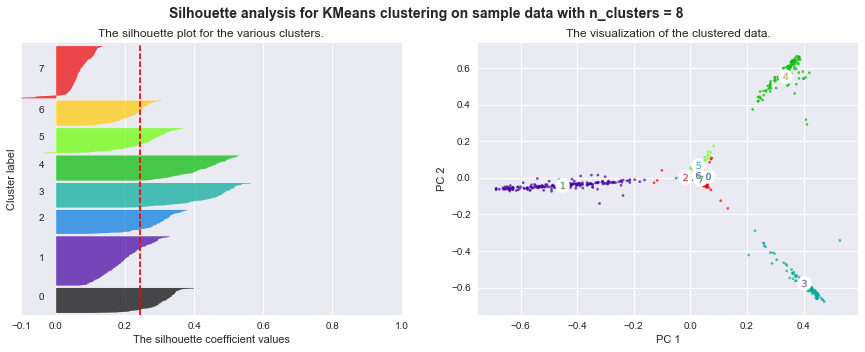

For n_clusters = 8, The average silhouette_score is : 0.243


In [108]:
X = novelsTFVects.toarray()   
plotSilhouette(8, X) 

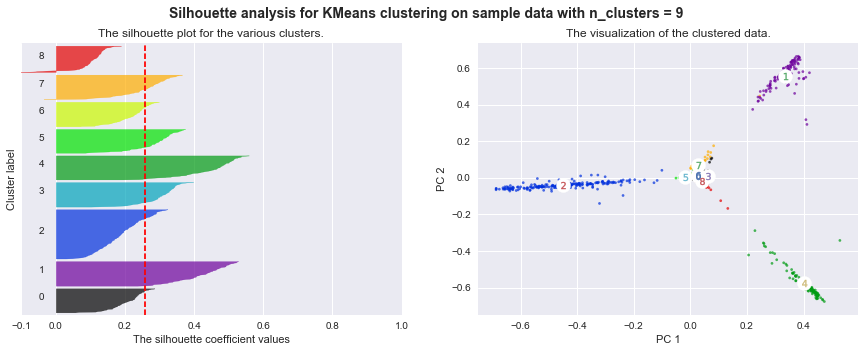

For n_clusters = 9, The average silhouette_score is : 0.258


In [109]:
X = novelsTFVects.toarray()   
plotSilhouette(9, X) 

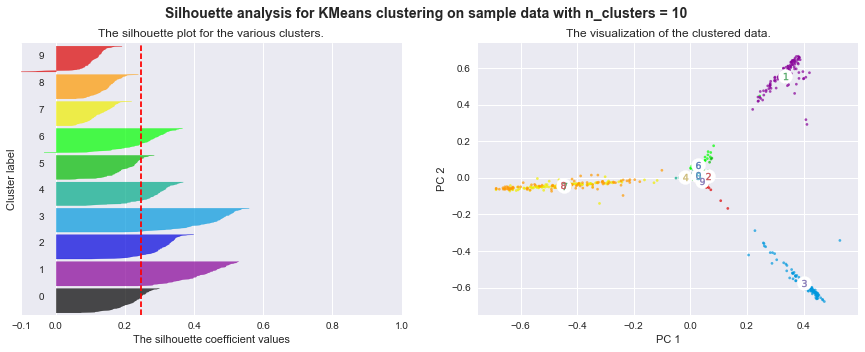

For n_clusters = 10, The average silhouette_score is : 0.247


In [110]:
X = novelsTFVects.toarray()   
plotSilhouette(10, X) 

After using Silhouette method, it seems that 9 cluster to be fit better. Also, each cluster has pretty strong clustering. I think it is because the name of specific terms and characters always tend to occur in the book chapters in the same book, so it could potentially confound the clustering results. So in order to do better clustering, I think it would be helpful to remove frequently occured nouns from each of 1000 chapters.

However, after viewing the plots and identiifying the optimal number of the clusters, I think translator effect is definitely something exists in the corpus of these novels. I think in the following weekly assignments, I need to use more computational methods to see if separating out translator effect would be possible.

### Initialize cluster finder and set cluster number to be 9

In [111]:
km = sklearn.cluster.KMeans(n_clusters=9, init='k-means++') 

### Caluclate the clusters  

In [112]:
km.fit(novelsTFVects) 

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=9, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

### Evaluate the clusters using some metrics

In [113]:
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(novelsDF['country'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(novelsDF['country'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(novelsDF['country'], km.labels_)))

Homogeneity: 1.000
Completeness: 0.150
V-measure: 0.261


### Adding cluster labels to the pandas dataframe                                 

In [126]:
novelsDF['kmeans_predictions'] = km.labels_                                     
novelsDF.iloc[:10]

,chapter,country,name,shortName,text,url,kmeans_predictions
0,chapter-1,China,Tales of Demons & Gods,tdg,"Even though it’s already the early summer, the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
1,chapter-2,China,Tales of Demons & Gods,tdg,"Naturally, Nie Li recognized this person. He’s...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
2,chapter-3,China,Tales of Demons & Gods,tdg,"You… In the hundreds of years of Glory City, L...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
3,chapter-4,China,Tales of Demons & Gods,tdg,"Aside from having a charming feel to her, she ...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
4,chapter-5,China,Tales of Demons & Gods,tdg,The Holy Orchid Institute’s annual school fee ...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
5,chapter-6,China,Tales of Demons & Gods,tdg,"Meanwhile, Du Ze and Nie Li were hiding in the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
6,chapter-7,China,Tales of Demons & Gods,tdg,Xiao Ning’er didn’t like being disrupted by ot...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
7,chapter-8,China,Tales of Demons & Gods,tdg,"Don’t misunderstand, I’m only treating your il...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
8,chapter-9,China,Tales of Demons & Gods,tdg,It’s time for Shen Xiu’s lesson again. However...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1
9,chapter-10,China,Tales of Demons & Gods,tdg,Xiao Ning’er also ate a few pieces of the past...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1


### Assess distinguishing features in each cluster

In [129]:
# Assess distinguishing features in each cluster                                
terms = ngTFVectorizer.get_feature_names()                                      
print("Top terms per cluster:")                                                 
order_centroids = km.cluster_centers_.argsort()[:, ::-1]                        
for i in range(9):                                                    
    print("Cluster %d:" % i)                                                    
    for ind in order_centroids[i, :10]:                                         
        print(' %s' % terms[ind])                                               
    print('\n')     

Top terms per cluster:
Cluster 0:
 shi
 village
 precious
 vicious
 willow
 children
 golden
 symbols
 bone
 divine


Cluster 1:
 nie
 tian
 ye
 shen
 demon
 ziyun
 soul
 ning
 tao
 pan


Cluster 2:
 lin
 dong
 lei
 yuan
 zhentian
 xie
 talisman
 manor
 tan
 steel


Cluster 3:
 qiye
 cleansing
 incense
 immortal
 emperor
 protector
 physique
 saint
 huairen
 merit


Cluster 4:
 jiang
 duke
 eastern
 gouyu
 princess
 soaring
 meridians
 fatty
 pill
 xuan


Cluster 5:
 mu
 liu
 array
 northern
 territory
 ling
 mubai
 tang
 feng
 mo


Cluster 6:
 theo
 magic
 theodore
 vince
 tower
 circle
 sylvia
 veronica
 magician
 magicians


Cluster 7:
 che
 profound
 yun
 xia
 qingyue
 jasmine
 moon
 palace
 luocheng
 cloud


Cluster 8:
 qing
 shui
 yu
 yi
 shi
 situ
 wenren
 shuang
 sword
 xiantian




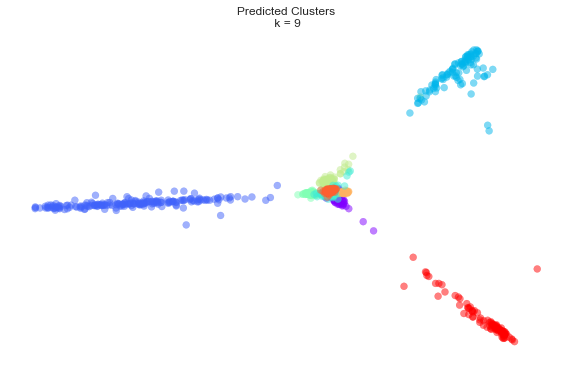

In [131]:
newCategories = list(plt.cm.rainbow(np.linspace(0, 1, 9)))
colors_p = [newCategories[l] for l in km.labels_]             
fig = plt.figure(figsize = (10,6))                                              
ax = fig.add_subplot(111)                                                       
ax.set_frame_on(False)                                                          
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())                                                                  
plt.yticks(())                                                                  
plt.title('Predicted Clusters\n k = 9')                                         
plt.show() 

In conclusion, the flat clustering method performs the best with cluster number equals to 9. It makes sense that there are chances that some of these novels of the same genre are very similiar to each other in terms of contents, verbs, adjectives, and nouns used, as well as translator effects. In addition, when each text is a chapter from 10 different books, there could be situations that in some chapters of the same scens there could be very similiar to each others. For example, bacause many of the books of choice are eastern fantasies involving fighting scenes and Kung Fu. So it could be possible that two chapters from two different books have very similiar discriptions and usage of words.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [132]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [133]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [134]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [135]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [136]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [137]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

array([[ 43.        ,  45.        ,   0.        ,   2.        ],
       [ 48.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [ 55.        , 202.        ,   0.37033177,   5.        ],
       [ 19.        , 154.        ,   0.40914841,   2.        ],
       [ 60.        ,  94.        ,   0.44134524,   2.        ],
       [ 12.        ,  99.        ,   0.45096656,   2.        ],
       [  1.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [ 52.        ,  96.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

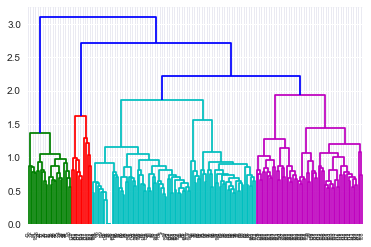

In [138]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

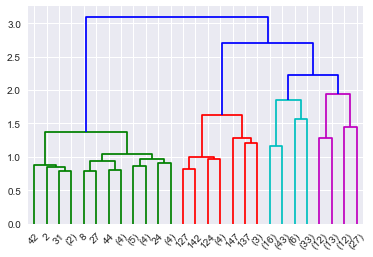

In [139]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [140]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4,
       3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4,
       2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [141]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [142]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,kmeans_predictions,wald_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",1,4
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,1,4
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,1,4
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",1,4
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,1,4
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,1,4
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,1,4
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",1,4
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,1,3
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,1,4


# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [143]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

And visualize the tree:

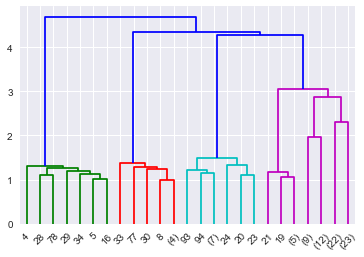

In [144]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [145]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

Create a word occurrence matrix measuring how similar the documents are to each other based on their number of shared words.

In [146]:
novelsCoocMat = novelsTFVects * novelsTFVects.T                                              
novelsCoocMat.setdiag(0)    

Compute a tree of nested clusters using the first 50 texts

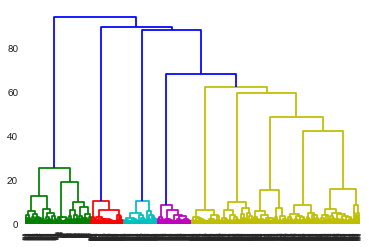

In [147]:
selectIndices = []                                                                           
indexToCat = []                                                                              
for c in set(novelsDF['name']):                                                              
    selectIndices += list(novelsDF[novelsDF['name'] == c].index)                        
    indexToCat += [c]                                                             
    #.groupby('category').sum()                                                              
subCoocMat = novelsCoocMat[selectIndices,:][:,selectIndices]                                 
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())                          
linkage_matrix[:10]                                                                          
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

Prune the tree to make it look better

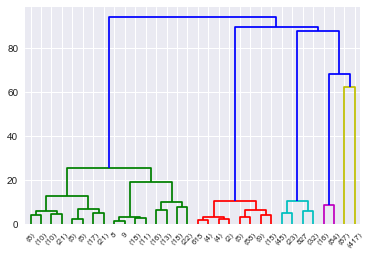

In [149]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)  

Second Approach: cutting the tree into n branches           

In [151]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')       

Implement the method on the full data set

In [152]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(novelsCoocMat.toarray())                  
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")                                                          
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(novelsDF['name'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(novelsDF['name'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(novelsDF['name'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(novelsDF['name'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.458
Completeness: 0.973
V-measure: 0.623
Adjusted Rand Score: 0.256


In [165]:
list(set(hierarchicalClusters_full))

[1, 2, 3, 4]

In [160]:
novelsDF['wald_pred'] = hierarchicalClusters_full
novelsDF.iloc[:10]

,chapter,country,name,shortName,text,url,kmeans_predictions,wald_pred
0,chapter-1,China,Tales of Demons & Gods,tdg,"Even though it’s already the early summer, the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
1,chapter-2,China,Tales of Demons & Gods,tdg,"Naturally, Nie Li recognized this person. He’s...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
2,chapter-3,China,Tales of Demons & Gods,tdg,"You… In the hundreds of years of Glory City, L...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
3,chapter-4,China,Tales of Demons & Gods,tdg,"Aside from having a charming feel to her, she ...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
4,chapter-5,China,Tales of Demons & Gods,tdg,The Holy Orchid Institute’s annual school fee ...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
5,chapter-6,China,Tales of Demons & Gods,tdg,"Meanwhile, Du Ze and Nie Li were hiding in the...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
6,chapter-7,China,Tales of Demons & Gods,tdg,Xiao Ning’er didn’t like being disrupted by ot...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
7,chapter-8,China,Tales of Demons & Gods,tdg,"Don’t misunderstand, I’m only treating your il...",http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
8,chapter-9,China,Tales of Demons & Gods,tdg,It’s time for Shen Xiu’s lesson again. However...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1
9,chapter-10,China,Tales of Demons & Gods,tdg,Xiao Ning’er also ate a few pieces of the past...,http://www.wuxiaworld.com/tdg-index/tdg-chapte...,1,1


In [185]:
bookNames = list(set(novelsDF['name']))
for i in range(10):
    print(bookNames[i])
    print("Wald's Method")
    print(novelsDF[novelsDF['name'] == bookNames[i]].wald_pred.value_counts(), '\n')

Lord of All Realms
Wald's Method
1    100
Name: wald_pred, dtype: int64 

Tales of Demons & Gods
Wald's Method
1    97
4     3
Name: wald_pred, dtype: int64 

Perfect World
Wald's Method
4    100
Name: wald_pred, dtype: int64 

Wu Dong Qian Kun
Wald's Method
3    100
Name: wald_pred, dtype: int64 

Against the Gods
Wald's Method
4    100
Name: wald_pred, dtype: int64 

Sovereign of the Three Realms
Wald's Method
4    100
Name: wald_pred, dtype: int64 

Ancient Strengthening Technique
Wald's Method
2    98
4     2
Name: wald_pred, dtype: int64 

The Book Eating Magician
Wald's Method
4    100
Name: wald_pred, dtype: int64 

The Great Ruler
Wald's Method
4    99
3     1
Name: wald_pred, dtype: int64 

Emperor's Domination
Wald's Method
4    100
Name: wald_pred, dtype: int64 



In [186]:
bookNames = list(set(novelsDF['name']))
for i in range(10):
    print(bookNames[i])
    print("K Means Method")
    print(novelsDF[novelsDF['name'] == bookNames[i]].kmeans_predictions.value_counts(), '\n')

Lord of All Realms
K Means Method
1    100
Name: kmeans_predictions, dtype: int64 

Tales of Demons & Gods
K Means Method
1    100
Name: kmeans_predictions, dtype: int64 

Perfect World
K Means Method
0    100
Name: kmeans_predictions, dtype: int64 

Wu Dong Qian Kun
K Means Method
2    100
Name: kmeans_predictions, dtype: int64 

Against the Gods
K Means Method
7    100
Name: kmeans_predictions, dtype: int64 

Sovereign of the Three Realms
K Means Method
4    97
0     3
Name: kmeans_predictions, dtype: int64 

Ancient Strengthening Technique
K Means Method
8    98
0     2
Name: kmeans_predictions, dtype: int64 

The Book Eating Magician
K Means Method
6    100
Name: kmeans_predictions, dtype: int64 

The Great Ruler
K Means Method
5    100
Name: kmeans_predictions, dtype: int64 

Emperor's Domination
K Means Method
3    100
Name: kmeans_predictions, dtype: int64 



From observing the distribution of counts, we could tell there are 4 categories assigned by Wald's method. First category contains novels: "Lord of All Relms", "Tales of Demons & Gods", second category contains: "Ancient Strengthening Technique", third category contains: "Wu Dong Qian Kun", and the last category contains: "Perfect World", "Against the Gods", "Sovereign of the Three Realms", "The Book Eating Magician". I think according to this categorization, Wald's method is more likely to cluster those chapters by genres, while K-means clusters chapters by books. 

Also, I was surprised to find out even Wald's Method make "Wu Dong Qian Kun" to be a separate category. I find it to be very interesting. I have personally read the book, and I do see it to be similiar, and supposedly, to be in the same cluster of "Perfect World" or "Against the Gods". So I think the reason could be translator effect might be significant in these book and the effect is too great that it has somehow changed the content and machine understanding of the book content.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [67]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,..."


In [169]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [170]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [171]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [172]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [173]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [174]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(7, 0.969294597957461)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [175]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [176]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(3, 0.957524367291495)]",0.0,0.000000,0.000000,0.957524,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
101,02Feb2007Kennedy10.txt,"[(2, 0.681230910385067), (3, 0.278345173237307...",0.0,0.000000,0.681231,0.278345,0.000000,0.000000,0.034640,0.000000,0.000000,0.0
201,04May2006Kennedy8.txt,"[(2, 0.14193337438881423), (4, 0.0593924887443...",0.0,0.000000,0.141933,0.000000,0.059392,0.000000,0.000000,0.000000,0.796419,0.0
301,06Jun2007Kennedy1.txt,"[(8, 0.9972948539788097)]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997295,0.0
401,08Feb2005Kennedy0.txt,"[(2, 0.4229373997910997), (7, 0.567901702088982)]",0.0,0.000000,0.422937,0.000000,0.000000,0.000000,0.000000,0.567902,0.000000,0.0
501,09Nov2005Kennedy11.txt,"[(2, 0.9399099223074308)]",0.0,0.000000,0.939910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
601,11Nov2005Kennedy6.txt,"[(2, 0.9598549639759962)]",0.0,0.000000,0.959855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
701,13Jun2006Kennedy1.txt,"[(2, 0.19938307030957544), (6, 0.0491290277434...",0.0,0.000000,0.199383,0.000000,0.000000,0.000000,0.049129,0.630776,0.118150,0.0
801,15Dec2005Kennedy5.txt,"[(1, 0.4985529149403794), (2, 0.01689768766433...",0.0,0.498553,0.016898,0.000000,0.000000,0.000000,0.000000,0.464744,0.018406,0.0
901,16May2007Kennedy5.txt,"[(1, 0.24436215083798424), (5, 0.7178752429653...",0.0,0.244362,0.000000,0.000000,0.000000,0.717875,0.000000,0.000000,0.000000,0.0


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [177]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.969295,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.957524,0.0,0.000000,0.0,0.000000,0.000000,0.00000
2,0.000000,0.991204,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.991574,0.0,0.000000,0.000000,0.00000
4,0.000000,0.194027,0.177288,0.000000,0.0,0.163045,0.0,0.000000,0.463606,0.00000
5,0.000000,0.000000,0.000000,0.000000,0.0,0.990703,0.0,0.000000,0.000000,0.00000
6,0.415036,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.568333,0.000000,0.00000
7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.208397,0.75765
8,0.000000,0.994868,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000
9,0.000000,0.966114,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000


First we can visualize as a stacked bar chart:

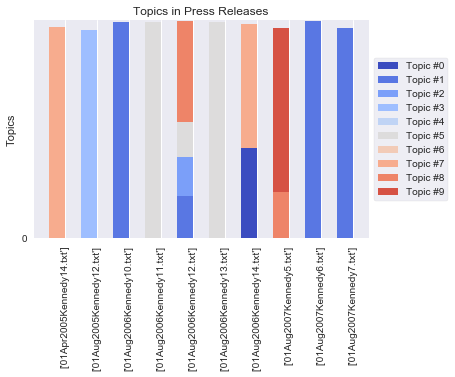

In [178]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

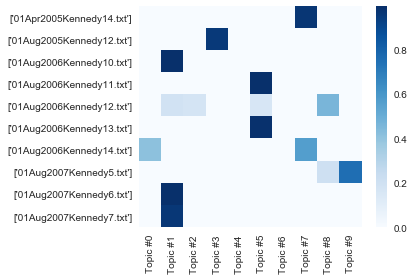

In [179]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [180]:
senlda.show_topic(1)

[('loan', 0.03164309733137902),
 ('lender', 0.01791002018762426),
 ('worker', 0.014212791576926571),
 ('fund', 0.013319085493736957),
 ('govern', 0.009229003063054747),
 ('wage', 0.009175326144113528),
 ('aid', 0.008531122458306346),
 ('inform', 0.007057239031574895),
 ('rate', 0.006580243009840534),
 ('minimum', 0.006494093616103825)]

And if we want to make a dataFrame:

In [181]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,teacher,loan,worker,minimum,head,worker,author,fund,worker,fund
1,worker,lender,fund,worker,wage,pension,govern,import,fund,depart
2,import,worker,troop,wage,worker,wage,head,wagon,fail,govern
3,teach,fund,import,fund,fund,fund,worker,depart,wagon,author
4,wagon,govern,wagon,govern,teacher,minimum,employ,head,amend,victim
5,amend,wage,iraqi,wagon,depart,victim,commit,worker,author,worker
6,rule,aid,depart,import,inform,wagon,wagon,effect,import,inform
7,fund,inform,employ,depart,import,unit,iraqi,doe,wage,wagon
8,citizen,rate,govern,rate,minimum,fda,unit,commit,stem,doe
9,assist,minimum,unit,unit,document,mental,fund,standard,loan,chip


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

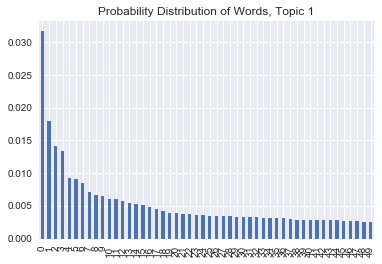

In [182]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [183]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

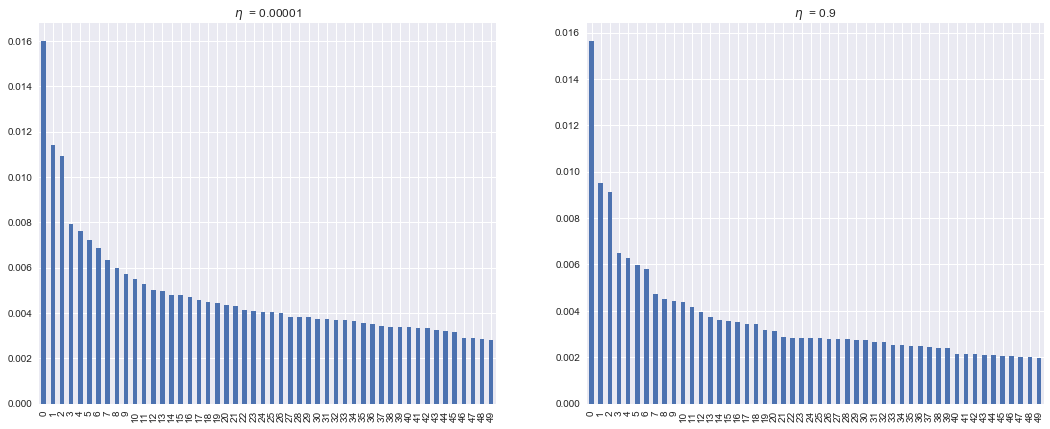

In [184]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

### Aggregate all books

In [196]:
booksDF = pandas.DataFrame(novelsDF.groupby('name').apply(lambda x: x.sum())['text'])

In [197]:
booksDF

,text
name,
Against the Gods,What’s going on… How is it that I have not die...
Ancient Strengthening Technique,"Sitting atop of a hillside, was a little boy, ..."
Emperor's Domination,A young shepherd’s herd of sheep made noises t...
Lord of All Realms,"As night fell, the plainly dressed Nie Qian le..."
Perfect World,"Sunlight passed through the dyed clouds, scatt..."
Sovereign of the Three Realms,Am I dead? Am I suffering through the fires of...
Tales of Demons & Gods,"Even though it’s already the early summer, the..."
The Book Eating Magician,A man with dark circles under his eyes called ...
The Great Ruler,Within the clearing where the sunlight project...


### Create a Dictionary that maps tokens to ids

In [200]:
booksDF['tokenized_plot'] = booksDF['text'].apply(lambda x: nltk.word_tokenize(x))
booksDF['normalized_tokens'] = booksDF['tokenized_plot'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))
booksDF['reduced_tokens'] = booksDF['normalized_tokens'].apply(lambda x: dropMissing(x, ngTFVectorizer.vocabulary_.keys()))
bookDict = gensim.corpora.Dictionary(booksDF['reduced_tokens'])

### For each of the texts create a list of tuples containing each token and its count

In [201]:
novelsCorpus = [bookDict.doc2bow(text) for text in booksDF['reduced_tokens']]

### Serialize the corpus as a file and load it

In [202]:
gensim.corpora.MmCorpus.serialize('novels.mm', novelsCorpus)
plotmm = gensim.corpora.MmCorpus('novels.mm')

### Now we have a correctly formatted corpus that we can use for topic modeling and induction

In [203]:
novelslda = gensim.models.ldamodel.LdaModel(corpus=novelsmm, id2word=bookDict, num_topics=10, alpha='auto', eta='auto')

### Inspect the degree to which distinct texts load on different topics

In [204]:
novels1Bow = bookDict.doc2bow(booksDF['reduced_tokens'][0])
novels1lda = novelslda[novels1Bow]
print("The topics of the plot summaries from {}".format(booksDF.index[0]), "are: {}".format(novels1lda))

The topics of the plot summaries from Against the Gods are: [(5, 0.9999311940902768)]


### Construct a pandas dataframe to see which topics our model predicts the plot summary load on

In [210]:
novels_ldaDF = pandas.DataFrame({
         'novel' : booksDF.index,
         'topics' : [novelslda[bookDict.doc2bow(l)] for l in booksDF['reduced_tokens']]
     })

# Make each topic its own column
## Dict to temporally hold the probabilities
novels_topicsProbDict = {i : [0] * len(novels_ldaDF) for i in range(novelslda.num_topics)}

## Load them into the dict
for index, topicTuples in enumerate(novels_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        novels_topicsProbDict[topicNum][index] = prob

## Update the DataFrame
for topicNum in range(novelslda.num_topics):
    novels_ldaDF['topic_{}'.format(topicNum)] = novels_topicsProbDict[topicNum]

In [212]:
novels_ldaDF

,novel,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Against the Gods,"[(5, 0.9999311926221002)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.999931,0.000000,0.000000,0.000000,0.000000
1,Ancient Strengthening Technique,"[(5, 0.9954416892718824)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.995442,0.000000,0.000000,0.000000,0.000000
2,Emperor's Domination,"[(0, 0.933792191829624), (8, 0.061669864647119...",0.933792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061670,0.000000
3,Lord of All Realms,"[(0, 0.6726733719935836), (1, 0.16825231849492...",0.672673,0.168252,0.000000,0.000000,0.000000,0.000000,0.000000,0.127405,0.024045,0.000000
4,Perfect World,"[(3, 0.9961178999063893)]",0.000000,0.000000,0.000000,0.996118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Sovereign of the Three Realms,"[(9, 0.9999350918003279)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999935
6,Tales of Demons & Gods,"[(0, 0.9999406567987873)]",0.999941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,The Book Eating Magician,"[(4, 0.9999033947123425)]",0.000000,0.000000,0.000000,0.000000,0.999903,0.000000,0.000000,0.000000,0.000000,0.000000
8,The Great Ruler,"[(6, 0.7255106589422263), (7, 0.27443027315192...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.725511,0.274430,0.000000,0.000000
9,Wu Dong Qian Kun,"[(2, 0.9999334857783844)]",0.000000,0.000000,0.999933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Visualize topics as a stacked bar chart

After visualizing the bar chart, it is interesting but understandable to see that most of the clusters have one and only one topic. It makes sense and proved our previous clusters method was good and accurate because one novels is expectedly to have one topic. 

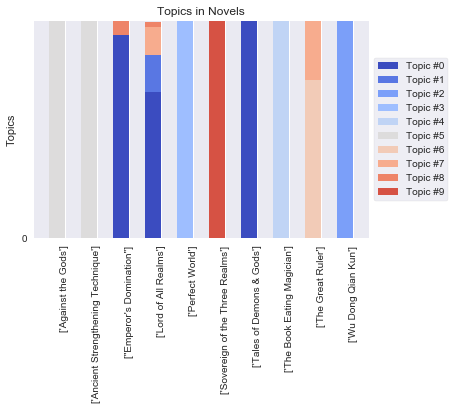

In [216]:
N = 10
K = novelslda.num_topics  # N documents, K topics
novels_ldaDFVis = novels_ldaDF[['topic_%d' %x for x in range(K)]].as_matrix(columns=None)
novels_ldaDFVisNames = novels_ldaDF[['novel']].as_matrix(columns=None)

ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, novels_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, novels_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += novels_ldaDFVis[:, k]
    plots.append(p)
    
plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Novels')
plt.xticks(ind+width/2, novels_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

### Visualize the heatmap

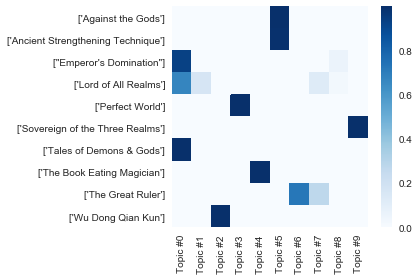

In [218]:
# Visualize as a heat map
plt.pcolor(novels_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(novels_ldaDFVis.shape[0])+0.5, novels_ldaDFVisNames);
plt.xticks(np.arange(novels_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

### Create a pandas df to assess top words from each topic 

In [221]:
novelsTopicsDict = {}
for topicNum in range(novelslda.num_topics):
    topicWords = [w for w, p in novelslda.show_topic(topicNum)]
    novelsTopicsDict['Topic_{}'.format(topicNum)] = topicWords

novelsWordRanksDF = pandas.DataFrame(novelsTopicsDict)
novelsWordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,nie,nie,lin,nie,theo,qing,mu,jiang,lin,jiang
1,demon,qing,dong,qing,magic,che,nie,mu,dong,duke
2,tian,lin,yuan,shui,qing,shui,qing,nie,tian,pill
3,ye,shui,lei,bone,magician,profound,jiang,lin,nie,mu
4,shen,mu,profound,tian,che,yun,shui,tian,mu,eastern
5,jiang,dong,nie,shi,profound,nie,liu,liu,yun,lin
6,soul,tian,che,appear,shui,lin,feng,duke,yuan,hall
7,yun,theo,zhentian,precious,tower,mu,pill,feng,final,king
8,ziyun,magic,yun,profound,yun,xia,appear,dong,jiang,magic
9,profound,demon,bone,mu,book,tian,array,appear,lei,qing


### Plot distribution of words over a topic

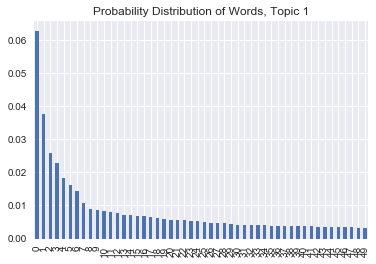

In [220]:
topic1_df = pandas.DataFrame(novelslda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

From the above probability distribution of words, we could observe direct translation effect of the book by observing the effect of how translators use their vocabulary. We could directly see that each book has chapters that always repeat several words a lot. For example, it could be the name of the leading characters, the name of a kong fu, the name of the clan, and etc. However, from my first-hand experience, I do see it to be not only a translator effect but also author effect. In the original Chinese version of these novels, authors tend to have the same habit of repetition. So, I am interested to see if the possibility of separating out author effect and translator using translated text would be possible. 

### Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes

In order to simplify the repetitive topic segmentation processes, I decided to create several helper functions that could simplify the process and visualize the same type of results.

In [224]:
def topicModeling(numTopics, alpha, eta, corpus = novelsmm, id2word = bookDict):
    novelslda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                num_topics=numTopics, 
                                                alpha=alpha, 
                                                eta=eta)
    return novelslda

In [257]:
def bookTopicDF(novelslda, bookDict=bookDict, booksDF=booksDF):
    novels_ldaDF = pandas.DataFrame({
            'novel' : booksDF.index,
            'topics' : [novelslda[bookDict.doc2bow(l)] for l in booksDF['reduced_tokens']]
        })
    # Make each topic its own column
    ## Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(novels_ldaDF) for i in range(novelslda.num_topics)}

    ## Load them into the dict
    for index, topicTuples in enumerate(novels_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    ## Update the DataFrame
    for topicNum in range(novelslda.num_topics):
        novels_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
        
    return novels_ldaDF

In [238]:
def preparePlot(novelslda, novelsldaDF):
    K = novelslda.num_topics  # N documents, K topics
    novels_ldaDFVis = novelsldaDF[['topic_%d' %x for x in range(K)]].as_matrix(columns=None)
    novels_ldaDFVisNames = novelsldaDF[['novel']].as_matrix(columns=None)
    return K, novels_ldaDFVis, novels_ldaDFVisNames

In [234]:
def bar_chart(K, novels_ldaDFVis, novels_ldaDFVisNames):
    N = 10
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, novels_ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, novels_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += novels_ldaDFVis[:, k]
        plots.append(p)

    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title('Topics in Novels')
    plt.xticks(ind+width/2, novels_ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

In [222]:
# Visualize as a heat map
def heatMap(K, novels_ldaDFVis, novels_ldaDFVisNames):
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.pcolor(novels_ldaDFVis, norm=None, cmap='Blues')
    plt.yticks(np.arange(novels_ldaDFVis.shape[0])+0.5, novels_ldaDFVisNames);
    plt.xticks(np.arange(novels_ldaDFVis.shape[1])+0.5, topic_labels);

    # flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
    plt.gca().invert_yaxis()

    # rotate the ticks on the x-axis
    plt.xticks(rotation=90)

    # add a legend
    plt.colorbar(cmap='Blues')
    plt.tight_layout()  # fixes margins
    plt.show()

A Function to catch the top words from each topic

In [250]:
# Make a pandas dataframe to look at the top words from each topic
def topic_topWords(novelslda):
    novels_topicsDict = {}
    for topicNum in range(novelslda.num_topics):
        topicWords = [w for w, p in novelslda.show_topic(topicNum)]
        novels_topicsDict['Topic_{}'.format(topicNum)] = topicWords

    novels_wordRanksDF = pandas.DataFrame(novels_topicsDict)
    return novels_wordRanksDF

Visualize the distribution of words over any single topic

In [223]:
def topic_words_dist(novelslda, topicNum):
    topic_df = pandas.DataFrame(novelslda.show_topic(topicNum, topn=50))
    plt.figure()
    topic_df.plot.bar(legend = False)
    plt.title('Probability Distribution of Words, Topic {}'.format(topicNum))
    plt.show()

### Tuning parameters to see differences

### Set the number of topics to be 7, and $\alpha=0.1$, and $\eta = 0.1$

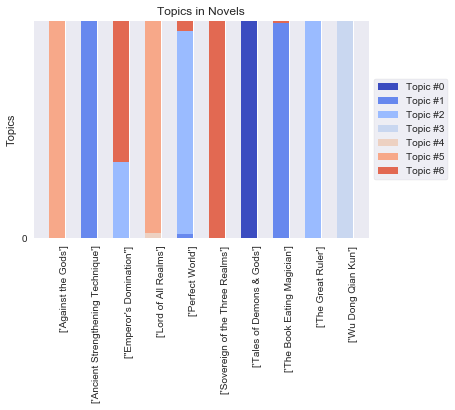

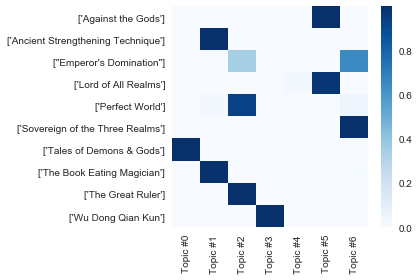

  Topic_0 Topic_1 Topic_2 Topic_3 Topic_4   Topic_5   Topic_6
0     nie    qing      mu     lin     nie       nie     jiang
1   demon    shui     nie    dong    qing  profound     magic
2    shen    theo   jiang     nie      mu       che      theo
3   jiang   jiang     liu    yuan    shui      tian      duke
4      ye   magic     lin     lei    tian       yun       che
5    qing      mu    feng   demon     che      qing      qing
6    soul     nie    bone      mu     liu      shui  profound
7   ziyun     shi  appear    qing   jiang     jiang       yun
8      mu      yu      mo      ye  appear        mu    appear
9    ning  appear    tian    soul   magic       xia   emperor


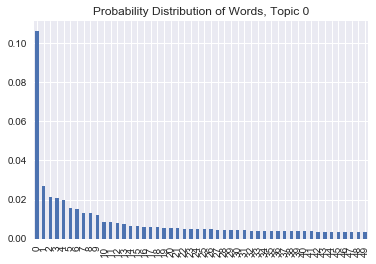

In [268]:
novelslda611 = topicModeling(7, 0.1, 0.1)
novelslda611DF = bookTopicDF(novelslda611)
K611, novelslda611DFVis1, novelslda611DFVisNames1 = preparePlot(novelslda611, novelslda611DF)
bar_chart(K611, novelslda611DFVis1, novelslda611DFVisNames1)
heatMap(K611, novelslda611DFVis1, novelslda611DFVisNames1)
print(topic_topWords(novelslda611))
topic_words_dist(novelslda611, 0)

### Set the number of topics to be 7, and $\alpha=0.5$, and $\eta = 0.1$

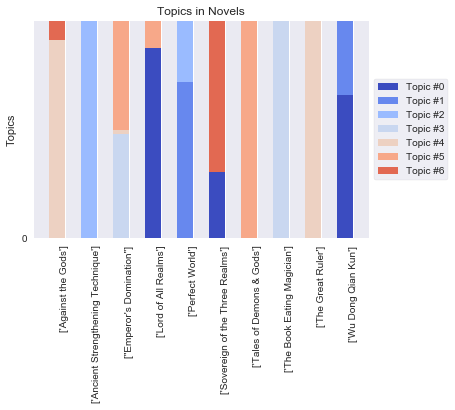

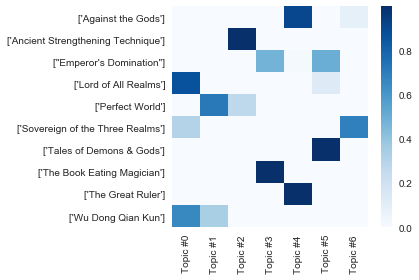

  Topic_0 Topic_1   Topic_2   Topic_3   Topic_4 Topic_5   Topic_6
0     nie    qing      qing       nie        mu     nie       nie
1   jiang    shui      shui      theo  profound   demon     jiang
2     lin     lin       shi     magic       lin      ye       che
3    tian    dong        yi       lin       liu    shen  profound
4    dong    theo        yu      dong       che    soul     demon
5      mu   magic       nie     jiang       yun   ziyun        ye
6    yuan     shi       che      tian      theo    tian       lin
7     yun  appear  profound     tower      dong      mu      duke
8    duke      yu     sword  magician        mo    ning       yun
9    feng      yi     grade     demon     array     lin      soul


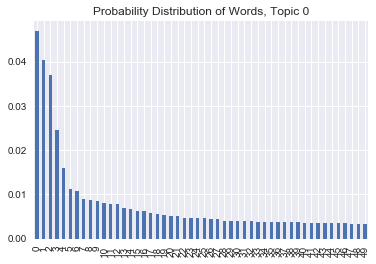

In [269]:
novelslda611 = topicModeling(7, 0.5, 0.1)
novelslda611DF = bookTopicDF(novelslda611)
K611, novelslda611DFVis1, novelslda611DFVisNames1 = preparePlot(novelslda611, novelslda611DF)
bar_chart(K611, novelslda611DFVis1, novelslda611DFVisNames1)
heatMap(K611, novelslda611DFVis1, novelslda611DFVisNames1)
print(topic_topWords(novelslda611))
topic_words_dist(novelslda611, 0)

Set the number of topics to be fixed to be 7, the distribution of top words within topic 0 has become less distinct. In addition, after increasing $\alpha$, we could see the number of tipics within each clusters have increased and become more complex. This makes sense since shrinking the number of clusters would make each cluster to contain more topics. However, the top words within each topic still has pretty siginificant bias as they are all distinguishing words of each book.

### Set the number of topics to be 7, and $\alpha=0.5$, and $\eta = 0.5$

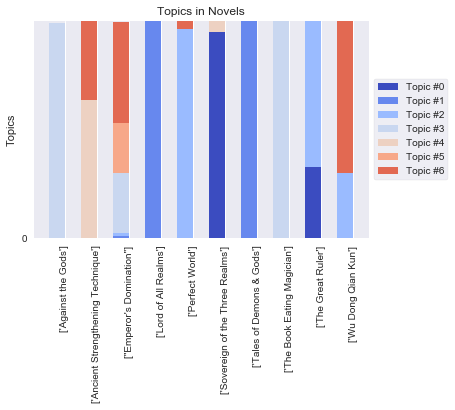

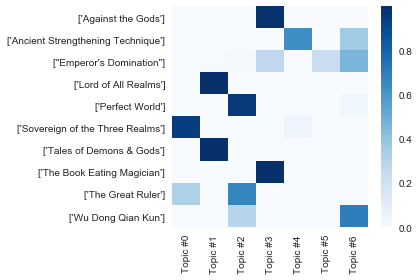

    Topic_0 Topic_1 Topic_2   Topic_3 Topic_4   Topic_5   Topic_6
0     jiang     nie     lin  profound    qing       che      qing
1        mu    tian      mu       che    shui        mu       lin
2       nie   jiang    dong      theo   jiang       nie      shui
3      duke   demon     liu       yun     lin       yun      dong
4  profound    qing    yuan        mu     nie  profound  profound
5       che    theo     lei     magic    tian      theo       lei
6       liu    soul     nie       nie    dong     magic      yuan
7       yun    shen  appear       xia    duke       lin       che
8       lin      ye     shi    appear      yu       liu       yun
9    appear   magic   jiang      moon    pill    appear       shi


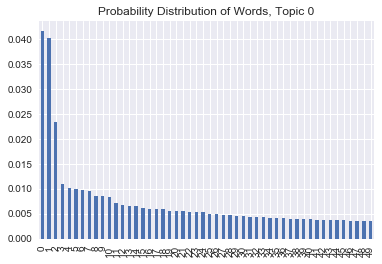

In [272]:
novelslda611 = topicModeling(7, 0.5, 0.5)
novelslda611DF = bookTopicDF(novelslda611)
K611, novelslda611DFVis1, novelslda611DFVisNames1 = preparePlot(novelslda611, novelslda611DF)
bar_chart(K611, novelslda611DFVis1, novelslda611DFVisNames1)
heatMap(K611, novelslda611DFVis1, novelslda611DFVisNames1)
print(topic_topWords(novelslda611))
topic_words_dist(novelslda611, 0)

After increasing the $\eta$, we could see the distincive top words has reduced. Topics composition within each book also have changed. However, we are able to observe some very repetitive adjectives in each topic such as "profound". This is pretty interesting to observe but makes sense because they are all eastern fantasies. 

### Set the number of topics to be 7, and $\alpha=0.8$, and $\eta = 0.5$

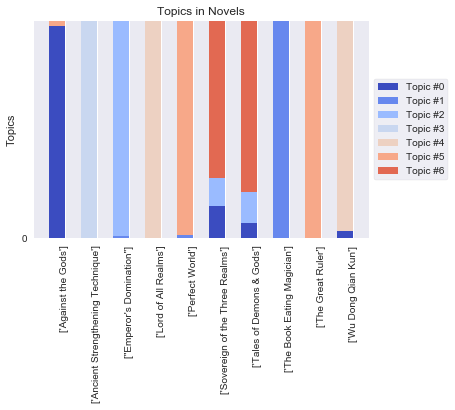

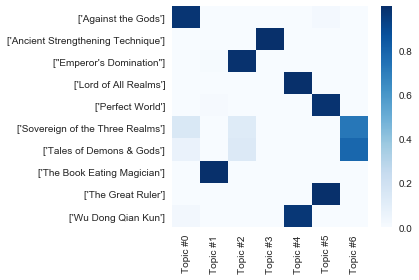

    Topic_0   Topic_1   Topic_2   Topic_3 Topic_4   Topic_5 Topic_6
0       nie      theo       nie      qing     nie        mu     nie
1       lin     magic     jiang      shui     lin     jiang   jiang
2     jiang        mu     demon       nie    tian       nie      mu
3      dong  magician       yun        mu    dong       liu     lin
4  profound       nie       che        yu   jiang       shi    dong
5       che       shi  profound        yi    yuan       che      ye
6       yun    appear        mu       liu     lei  profound   demon
7      theo     sword    appear       che     yun  precious  appear
8     demon      book      tian  profound    bone      bone    duke
9     magic       liu      dong      tian    qian    appear    soul


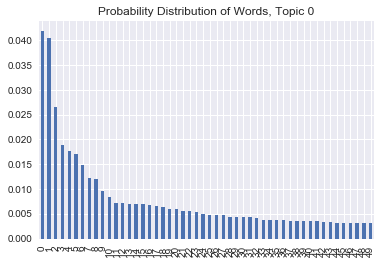

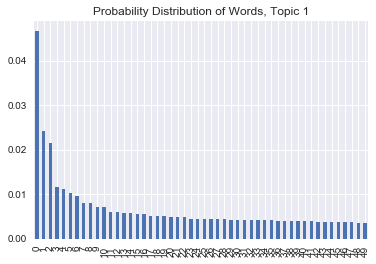

In [275]:
novelslda611 = topicModeling(7, 0.8, 0.5)
novelslda611DF = bookTopicDF(novelslda611)
K611, novelslda611DFVis1, novelslda611DFVisNames1 = preparePlot(novelslda611, novelslda611DF)
bar_chart(K611, novelslda611DFVis1, novelslda611DFVisNames1)
heatMap(K611, novelslda611DFVis1, novelslda611DFVisNames1)
print(topic_topWords(novelslda611))
topic_words_dist(novelslda611, 0)
topic_words_dist(novelslda611, 1)

Maitaining the same number of topic and largely increasing parameter $\alpha$, we could see one obvious change is there is more distinctive words shown in probability distribution of words. Also, looking into the dataframe of top words in each topics. More adjectives have occurred, such as "profound" and "precious". Composition of topics within each book has slightly changed from low alpha score.

I would like to make more attempts and leverage the technique of topic modeling because it could potentially help with identifying translator effect from the English translated text by compairng topics occured within each chapter with clustering of words. 